<a href="https://colab.research.google.com/github/uni-3/ml-at-work-exercise/blob/master/notebooks/3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 9章 uplift modeling

p 192

In [0]:
import random

In [0]:
# dataset生成
def generate_sample_data(num, seed=123):
    # returns
    # コンバージョンしたか否か
    is_cv_list = []
    # 実験群か否か
    is_treat_list = []
    feature_vector_list = []
    
    random_instance = random.Random(seed)
    
    # 特徴量の数
    feature_num = 8
    # 統制群がもつ重み
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00]
    # 実験群に足される重み(介入により変化する重み)
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00]
    
    # ユーザの数だけ実行
    for i in range(num):
        # ランダムに特徴ベクトル生成 [0, 1]
        feature_vector = [
            random_instance.random() for n in range(feature_num)
        ]
        
        # 実験群の振り分け（ランダム）
        is_treat = random_instance.choice((True, False))

        # コンバージョンレートを計算 内積
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])
        
        # 実験群ならばさらにlift_weightと内積をとる
        if is_treat:
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])
            
        #  コンバージョンしたか否か、確率的に決まる
        is_cv = cv_rate > random_instance.random()
        
        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)
        
    return is_cv_list, is_treat_list, feature_vector_list

In [0]:
# 予測モデルの作成 
# 学習データ生成
sample_num = 10000
train_cvs, train_treats, train_feature_vectors = generate_sample_data(sample_num, seed=1)


In [0]:
# treatmentとcontrolに分離

treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(sample_num):
    # 実験群
    if train_treats[i]:
        treat_is_cv_list.append(train_cvs[i])
        treat_feature_vector_list .append(train_feature_vectors[i])
    # 統制群    
    else:
        control_is_cv_list.append(train_cvs[i])
        control_feature_vector_list .append(train_feature_vectors[i])
        
# コンバージョンレートを表示(各群の中でcvした人)
# 実験群3.69% 統制群3.62%
print('treatment_cvr:', treat_is_cv_list.count(True) / len(treat_is_cv_list))

print('control_cvr:', control_is_cv_list.count(True) / len(control_is_cv_list))

treatment_cvr: 0.036918778686888844
control_cvr: 0.03627981559430748


In [0]:
# 特徴量を元にセグメントして、どの層に効果があったのかみる
from sklearn.linear_model import LogisticRegression

In [0]:
treat_model = LogisticRegression(C=0.01,  solver='lbfgs') # in 0.22 changed to 'lbfgs'
control_model = LogisticRegression(C=0.01,  solver='lbfgs')

treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
# testデータの生成
test_cvs, test_treats, test_feature_vectors = generate_sample_data(sample_num, seed=42)

# cvを予測
treat_score = treat_model.predict_proba(test_feature_vectors)
control_score = control_model.predict_proba(test_feature_vectors)

In [0]:
# 各々の所属確率がでる
treat_score

array([[0.96735513, 0.03264487],
       [0.96609679, 0.03390321],
       [0.95806294, 0.04193706],
       ...,
       [0.96552777, 0.03447223],
       [0.95664114, 0.04335886],
       [0.96125385, 0.03874615]])

In [0]:
# uplift modelのスコア算出
# クラスの所属確率、1列目(コンバージョンした率)を使う
# スコアが高いと、実験群のCVRが良く（高い）、統制群のCVR悪い（低い）、介入効果があると言える、低いとその逆
score_list = treat_score[:, 1] / control_score[:, 1]
score_list

array([0.8876401 , 0.98507892, 1.10637765, ..., 1.10174057, 1.20632295,
       1.06180095])

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
plt.style.use('ggplot')
%matplotlib inline

In [0]:
# スコア降順に並べ替え
result = list(zip(test_cvs, test_treats, score_list))
result.sort(key=itemgetter(2), reverse=True)

result

In [0]:
# 10%ごとにカウント
qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    # 10%ごとに取り出す
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    # controlとtreatの数を数える
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item: item[1], quantiled_result)).count(False)
    
    # CV数を数える
    treat_cv = [item[0] for item in quantiled_result if item[1] is True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] is False].count(True)
    
    # CVRに変換、dfに入れる
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = "{}%-{}%".format(n * 10, (n+1) * 10)
    qdf.loc[label] = (treat_cvr, control_cvr)

In [0]:
qdf.head()

,treat_cvr,control_cvr
0%-10%,0.057732,0.025292
10%-20%,0.057654,0.028226
20%-30%,0.024341,0.043478
30%-40%,0.032787,0.023483
40%-50%,0.042169,0.033932


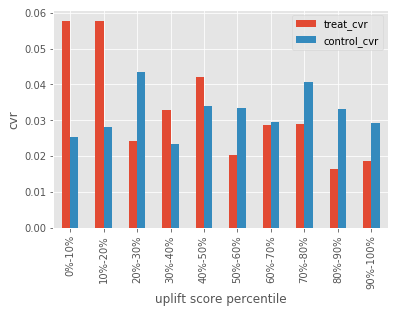

In [0]:
# スコアが高い人(左の方)に介入した方がコンバージョンあげやすいと言える
qdf.plot.bar()
plt.xlabel('uplift score percentile')
plt.ylabel('cvr')
plt.show()

#### AUUCの計算

In [0]:
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
        
    # liftの算出
    # 実験群がどれくらいの人数コンバージョンを変化させたか
    lift = (treat_cvr - control_cvr) * treat_uu
    
    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu,
                     treat_cv, control_cv, treat_cvr, control_cvr, lift])

df = pd.DataFrame(stat_data)

df.columns = [
    'is_cv', 'is_treat', 'score', 'treat_uu', 'control_uu'
    , 'treat_cv', 'control_cv', 'treat_cvr', 'control_cvr', 'lift'
]

# base lineを加える liftの終点についてデータの長さで割った数が各点になる
df['base_line'] = df.index * df['lift'][len(df.index) - 1] / len(df.index)

df.tail()

,is_cv,is_treat,score,treat_uu,control_uu,treat_cv,control_cv,treat_cvr,control_cvr,lift,base_line
9995,False,True,0.798062,4908,5088,161,163,0.032804,0.032036,3.766509,3.762361
9996,False,False,0.797344,4908,5089,161,163,0.032804,0.032030,3.797406,3.762738
9997,False,True,0.795940,4909,5089,161,163,0.032797,0.032030,3.765376,3.763114
9998,False,False,0.793056,4909,5090,161,163,0.032797,0.032024,3.796267,3.763491
9999,False,True,0.791288,4910,5090,161,163,0.032790,0.032024,3.764244,3.763867


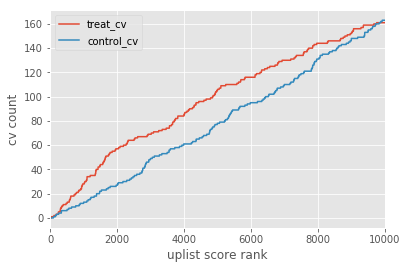

In [0]:
df.plot(y=['treat_cv', 'control_cv'],)
plt.xlabel('uplist score rank')
plt.ylabel('cv count')
plt.show()

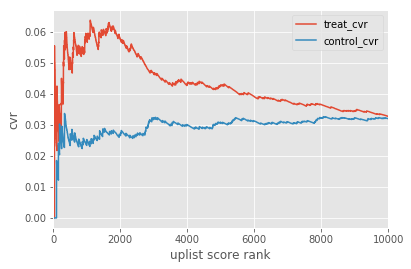

In [0]:
df.plot(y=['treat_cvr', 'control_cvr'],)
plt.xlabel('uplist score rank')
plt.ylabel('cvr')
plt.show()

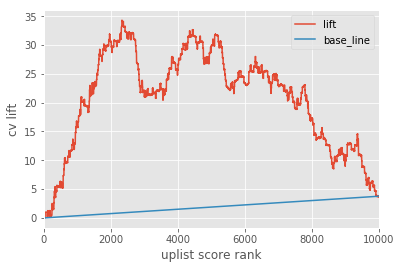

In [0]:
# スコア高い順なので、最後の方は、統制群が勝ち、cv liftは下がる
df.plot(y=['lift', 'base_line'],)
plt.xlabel('uplist score rank')
plt.ylabel('cv lift')
plt.show()

In [0]:
auuc = (df['lift'] - df['base_line']).sum() / len(df['lift'])
print('AUUC:', auuc)

AUUC: 18.79132546971009


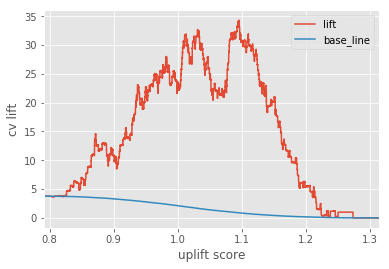

In [0]:
# どのスコアのユーザを対象とすれば良いか
df.plot(x='score', y=['lift', 'base_line'])
plt.xlabel('uplift score')
plt.ylabel('cv lift')
plt.show()